# **Exploratory Data Analysis (EDA) on IMDb Reviews Dataset**

This notebook walks through a **step-by-step EDA** on the IMDb dataset.  
By the end, you will learn:

- How to load and inspect raw text datasets.  
- How to analyze distributions (length, class balance).  
- How to extract meaningful vocabulary & n-grams.  
- How linguistic features differ across sentiments.  
- How to visualize separability of classes.  


In [20]:
# =============================
# 1. Setup & Imports
# =============================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")

sns.set(style="whitegrid", palette="muted", font_scale=1.2)


[nltk_data] Downloading package punkt to /Users/ravina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ravina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ravina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 📥 Load Dataset

We assume the IMDB dataset has been downloaded from [Stanford IMDB Sentiment dataset](https://ai.stanford.edu/~amaas/data/sentiment/) and extracted into the `data/` folder.

The folder structure should look like this:

```
data/
  aclImdb/
    train/
      pos/
      neg/
    test/
      pos/
      neg/
```

In [10]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /Users/ravina/Desktop/text_classification_project/notebooks


In [ ]:
# =============================
# 2. Load Data
# =============================

def load_imdb_dataset(data_dir):
    data = {"review": [], "sentiment": [], "split": []}
    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            path = os.path.join(data_dir, split, sentiment)
            for file in os.listdir(path):
                with open(os.path.join(path, file), "r", encoding="utf-8") as f:
                    data["review"].append(f.read())
                    data["sentiment"].append(sentiment)
                    data["split"].append(split)
    return pd.DataFrame(data)

# ✅ path of your dataset folder
data_dir = "../data/aclImdb"
df = load_imdb_dataset(data_dir)

df.head()


,review,sentiment,split
0,For a movie that gets no respect there sure ar...,pos,train
1,Bizarre horror movie filled with famous faces ...,pos,train
2,"A solid, if unremarkable film. Matthau, as Ein...",pos,train
3,It's a strange feeling to sit alone in a theat...,pos,train
4,"You probably all already know this by now, but...",pos,train


## 🔍 Dataset Overview

Dataset shape: (50000, 2)
sentiment
1    25000
0    25000
Name: count, dtype: int64


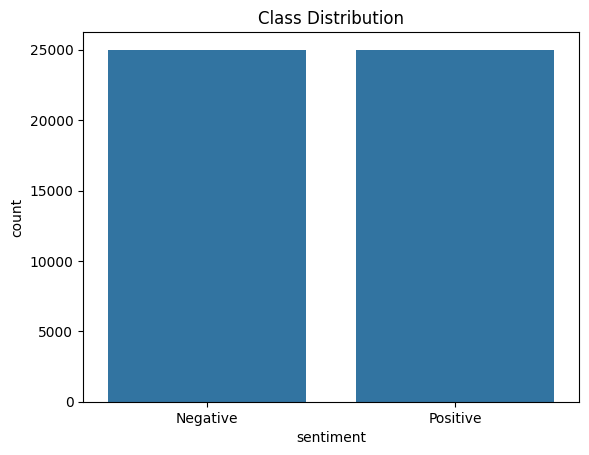

In [16]:

print(f"Dataset shape: {df.shape}")
print(df['sentiment'].value_counts())

# Show class balance
sns.countplot(x=df['sentiment'])
plt.xticks([0,1], ['Negative','Positive'])
plt.title("Class Distribution")
plt.show()


## 🧹 Text Preprocessing

We will:
- Lowercase text
- Remove HTML tags
- Remove punctuation
- Remove stopwords


In [17]:

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Apply preprocessing on sample
df['clean_review'] = df['review'].apply(clean_text)
df[['review','clean_review']].head()


,review,clean_review
0,For a movie that gets no respect there sure ar...,movie gets respect sure lot memorable quotes l...
1,Bizarre horror movie filled with famous faces ...,bizarre horror movie filled famous faces stole...
2,"A solid, if unremarkable film. Matthau, as Ein...",solid unremarkable film matthau einstein wonde...
3,It's a strange feeling to sit alone in a theat...,strange feeling sit alone theater occupied par...
4,"You probably all already know this by now, but...",probably already know additional episodes neve...


## 📏 Review Length Distribution

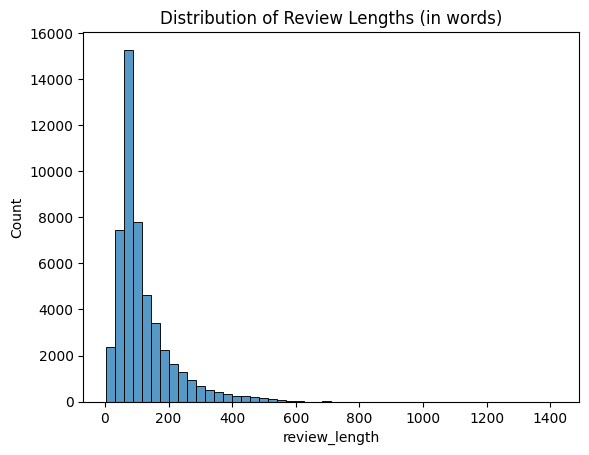

In [18]:

df['review_length'] = df['clean_review'].apply(lambda x: len(x.split()))
sns.histplot(df['review_length'], bins=50)
plt.title("Distribution of Review Lengths (in words)")
plt.show()


## ☁️ WordClouds

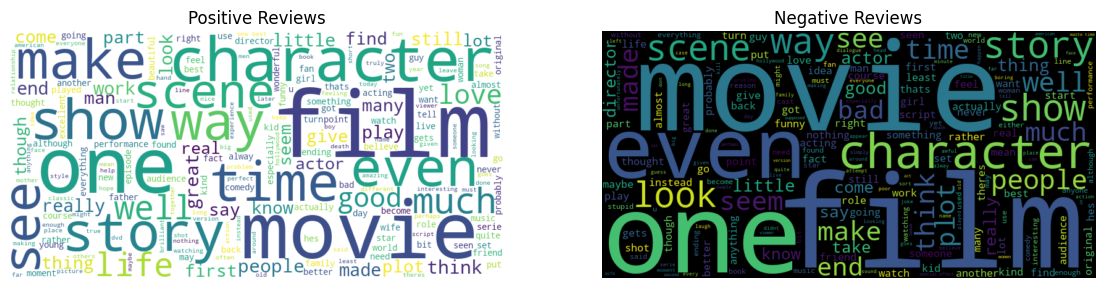

In [19]:

pos_text = " ".join(df[df['sentiment']==1]['clean_review'].tolist())
neg_text = " ".join(df[df['sentiment']==0]['clean_review'].tolist())

wordcloud_pos = WordCloud(width=800, height=400, background_color="white").generate(pos_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color="black").generate(neg_text)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews")

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews")
plt.show()
